In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
import re
import concurrent.futures
import tqdm
import multiprocessing
from functools import partial
import pickle

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from CHARMtools import spatialstat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_565416/1486363162.py:31: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [ ]:
def _post_process_cor(autocorr):
    autocorr = np.array(autocorr)
    autocorr[np.isinf(autocorr)] = np.nan
    means = np.nanmean(autocorr,axis=0)
    stderr = np.nanstd(autocorr,axis=0) / np.sqrt(np.sum(~np.isnan(autocorr), axis=0))
    return means, stderr

In [3]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2]

metadata["next_cellname"] = metadata["cellname"].sample(frac = 1,random_state=42).values
rnag1 = pd.read_csv("../data/RNAmats/counts.gene.genome1.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("../data/RNAmats/counts.gene.genome2.format.tsv.gz",sep='\t')
genes = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep='\t',header=None)
genes.columns = ["chrom","start","end","id","gene","strand"]

## G(r) analysis

In [ ]:
def _load_cell(cellname, cellname_next, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # inpeak fragments
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", 
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz", 
                     column_name="ct" ,keep_3prime=True,type="allelic_resolved")

    cell.tdg["atac_random"] = cell.tdg["atac"].sample(frac=1,random_state=42).values
    cell.tdg["ct_random"] = cell.tdg["ct"].sample(frac=1,random_state=42).values

    cell.calc_radial_position(if_rank=True,if_norm_mean=False)
    
    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes,column_name="rna")
    cell.tdg["if_expressed"] = (cell.tdg["rna"] >= 1).astype(int)
    cell.tdg["rna_random"] = cell.tdg["rna"].sample(frac=1,random_state=42).values
    
    #cell.subset(query='atac > 0 or ct > 0 or atac_next > 0 or ct_next > 0 or rna >= 1 or atac_random > 0 or ct_random > 0 or rna_random >= 1',in_place=True)
    cell.subset(query='atac > 0 or ct > 0 or rna >= 1 or atac_random > 0 or ct_random > 0 or rna_random >= 1',in_place=True)
    
    cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="ct",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="atac_random",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="ct_random",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="if_expressed",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="rna",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="rna_random",radius=2,type="sum",if_self=True)
    
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

def _load_cell_allpoints(cellname,resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )

    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    cell.calc_radial_position(if_rank=True,if_norm_mean=False)

    cell.add_bedGraph_data(
        path=f"/share/Data/public/ref_genome/mouse_ref/M23/CpG/normal_cpg/M23.CpG.5000.txt",
        column_name="CpG",
        type="all"
    )
    return cell
    

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], metadata['next_cellname'], [5000]*len(metadata)), total=len(metadata)))
    cells_allpoints = list(tqdm.tqdm(executor.map(_load_cell_allpoints, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))


100%|██████████| 720/720 [01:46<00:00,  6.76it/s]


In [5]:
atac_particles = []
ct_particles = []
rna_particles = []
mean_atac_particles_within_2pr = []
mean_ct_particles_within_2pr = []
mean_rna_particles_within_2pr = []
mean_atac_random_particles_within_2pr = []
mean_ct_random_particles_within_2pr = []
mean_rna_random_particles_within_2pr = []

for cell in tqdm.tqdm(cells):
    atac_particles.append(cell.tdg.query('atac > 0').shape[0])
    ct_particles.append(cell.tdg.query('ct > 0').shape[0])
    rna_particles.append(cell.tdg.query('rna >= 1').shape[0])
    mean_atac_particles_within_2pr.append(cell.tdg.query('atac > 0')['atac_sum_in_radius_2'].values.mean())
    mean_ct_particles_within_2pr.append(cell.tdg.query('ct > 0')['ct_sum_in_radius_2'].values.mean())
    mean_rna_particles_within_2pr.append(cell.tdg.query('rna >= 1')['rna_sum_in_radius_2'].values.mean())
    mean_atac_random_particles_within_2pr.append(cell.tdg.query('atac_random > 0')['atac_random_sum_in_radius_2'].values.mean())
    mean_ct_random_particles_within_2pr.append(cell.tdg.query('ct_random > 0')['ct_random_sum_in_radius_2'].values.mean())
    mean_rna_random_particles_within_2pr.append(cell.tdg.query('rna_random >= 1')['rna_random_sum_in_radius_2'].values.mean())
    

100%|██████████| 720/720 [00:32<00:00, 22.08it/s]


In [6]:
print("mean ATAC particles: ", np.mean(atac_particles))
print("mean H3K27me3 particles: ", np.mean(ct_particles))
print("mean RNA particles: ", np.mean(rna_particles))
print("---------------------------------------------------------")
print("mean ATAC particles within 2pr: ", np.mean(mean_atac_particles_within_2pr))
print("mean H3K27me3 particles within 2pr: ", np.mean(mean_ct_particles_within_2pr))
print("mean RNA particles within 2pr: ", np.mean(mean_rna_particles_within_2pr))
print("---------------------------------------------------------")
print("mean random ATAC particles within 2pr: ", np.mean(mean_atac_random_particles_within_2pr))
print("mean random H3K27me3 particles within 2pr: ", np.mean(mean_ct_random_particles_within_2pr))
print("mean random RNA particles within 2pr: ", np.mean(mean_rna_random_particles_within_2pr))

mean ATAC particles:  29154.19722222222
mean H3K27me3 particles:  58049.384722222225
mean RNA particles:  4667.5888888888885
---------------------------------------------------------
mean ATAC particles within 2pr:  3.830617162253918
mean H3K27me3 particles within 2pr:  6.682071093694994
mean RNA particles within 2pr:  3.185826545512161
---------------------------------------------------------
mean random ATAC particles within 2pr:  2.985356807511222
mean random H3K27me3 particles within 2pr:  5.1204794780624105
mean random RNA particles within 2pr:  2.7917062057975546


In [ ]:
def _calc_spatial_autocorr(cell,query,count_name=None):
    np.random.seed(42)
    df = cell.get_data().query(query).copy()
    if count_name is not None:
        df[count_name] = df[count_name].astype(int)
        points = np.repeat(df[["x","y","z"]].values, df[count_name].values, axis=0)
    else:
        points = df[["x","y","z"]].values.copy()

    if points.shape[0] > 5000:
        points = points[np.random.choice(points.shape[0], 5000, replace=False), :]
        return spatialstat.spatial_autocorr_3d(points,dr=0.5,max_dist=10,Nsim=4)[0]
    else:
        return np.array([np.nan for i in range(20)])

with concurrent.futures.ProcessPoolExecutor(max_workers=128,mp_context=multiprocessing.get_context("fork")) as executor:
    cor_atac = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='atac > 0',count_name='atac'),cells), total=len(cells)))
    cor_atac_random = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='atac_random > 0',count_name=None),cells), total=len(cells)))
    cor_all = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='chrom_code >= 0 ',count_name=None),cells_allpoints), total=len(cells_allpoints)))

100%|██████████| 720/720 [03:16<00:00,  3.66it/s]


In [ ]:
means_atac, stderr_atac = _post_process_cor(cor_atac)
means_atac_random, stderr_atac_random = _post_process_cor(cor_atac_random)
means_all, stderr_all = _post_process_cor(cor_all)

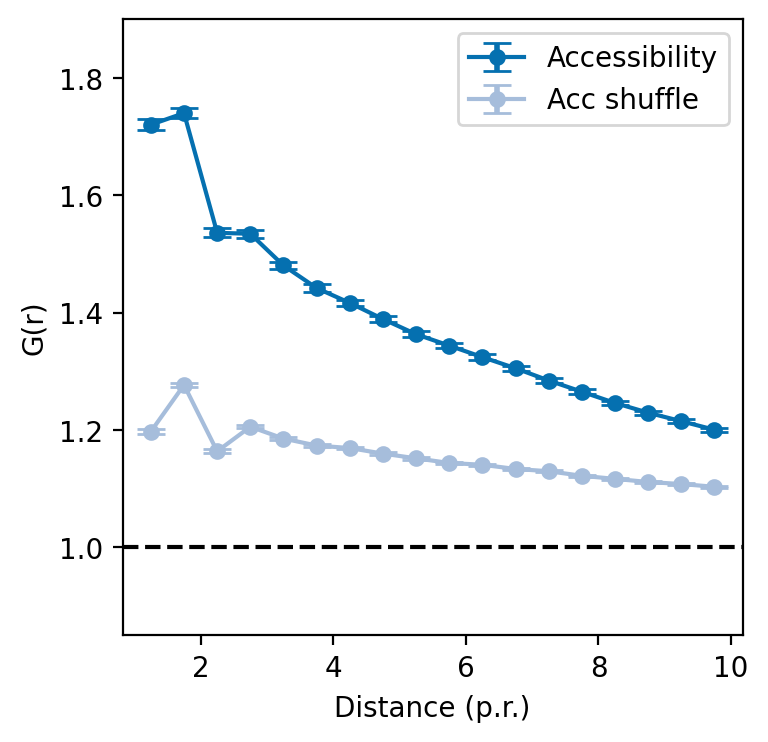

In [21]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
r = np.arange(0.25, 10, 0.5)
start_i = 2

plt.errorbar(r[start_i:],means_atac[start_i:],yerr=stderr_atac[start_i:],label='Accessibility',fmt='-o',ecolor='#0570b0',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#0570b0')
plt.errorbar(r[start_i:],means_atac_random[start_i:],yerr=stderr_atac_random[start_i:],label='Acc shuffle',fmt='-o',ecolor='#a6bddb',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#a6bddb')

plt.axhline(y=1, color='black', linestyle='--')

plt.legend()
#plt.xlim(0.75, 8)
plt.ylim(0.85, 1.9)
plt.xlabel('Distance (p.r.)')
plt.ylabel('G(r)')
# save pdf
plt.savefig('figures/spatial_autocorr_atac_mesc.pdf', bbox_inches='tight')

### Radial position control

In [ ]:
all_particles_list = []
for cell in cells:
    atac_positive_particles = cell.get_data().query('atac > 0')
    all_particles_list.append(atac_positive_particles[['radial_position']])
all_particles_df = pd.concat(all_particles_list, ignore_index=True)

sampled_df = all_particles_df.groupby(
    (all_particles_df['radial_position'] // 0.1)
).sample(n=1000, replace=True, random_state=42) 

In [42]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False 

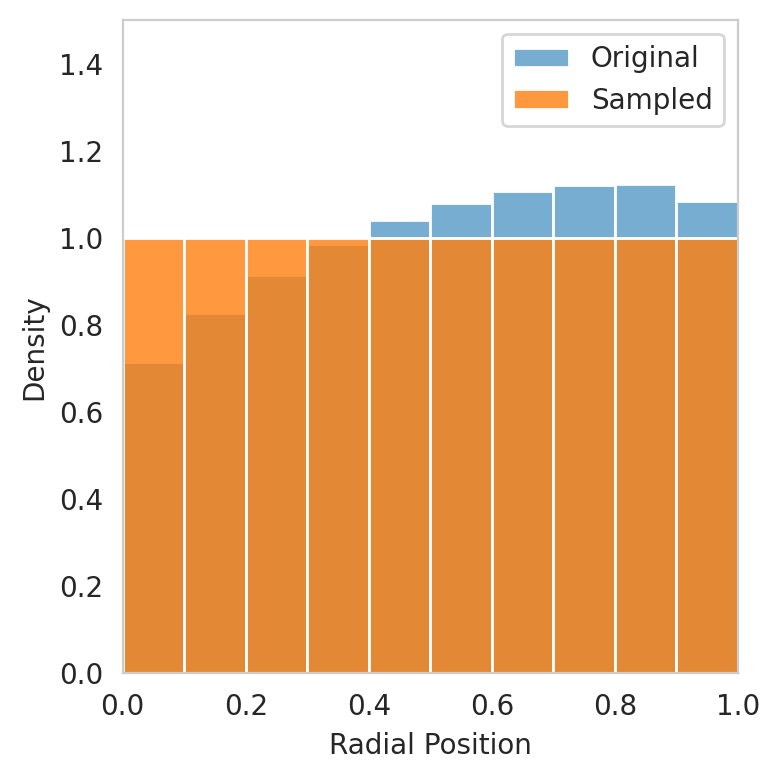

In [45]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.histplot(data=all_particles_df, x='radial_position', 
             bins=10, binrange=(0, 1), 
             stat='density',
             kde=False, 
             alpha=0.6, 
             label='Original',
             ax=ax)
sns.histplot(data=sampled_df, x='radial_position',
             bins=10, binrange=(0, 1),
             stat='density',
             kde=False,
             color=sns.color_palette()[1], 
             alpha=0.8,
             label='Sampled',
             ax=ax)

ax.legend()
ax.set_xlabel('Radial Position')
ax.set_ylabel('Density')
ax.set_xlim(0, 1)
ax.set_ylim(0,1.5)

plt.tight_layout()
plt.savefig('figures/sampled_atac_radialposition.pdf', bbox_inches='tight')

In [14]:
def _calc_spatial_autocorr(cell,query,count_name=None,rp_sample = False):
    np.random.seed(42)
    df = cell.get_data().query(query).copy()
    if rp_sample:
        df = df.groupby(df['radial_position']//0.1).sample(n=1000,replace=True)
    if count_name is not None:
        df[count_name] = df[count_name].astype(int)
        points = np.repeat(df[["x","y","z"]].values, df[count_name].values, axis=0)
    else:
        points = df[["x","y","z"]].values.copy()

    if points.shape[0] > 5000:
        points = points[np.random.choice(points.shape[0], 5000, replace=False), :]
        return spatialstat.spatial_autocorr_3d(points,dr=0.5,max_dist=10,Nsim=4)[0]
    else:
        return np.array([np.nan for i in range(20)])

with concurrent.futures.ProcessPoolExecutor(max_workers=128,mp_context=multiprocessing.get_context("fork")) as executor:
    cor_atac_sample = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='atac > 0',count_name='atac',rp_sample=True),cells), total=len(cells)))
    cor_atac_random_sample = list(tqdm.tqdm(executor.map(partial(_calc_spatial_autocorr,query='atac_random > 0',count_name=None),cells), total=len(cells)))

100%|██████████| 720/720 [03:13<00:00,  3.73it/s]


In [16]:
means_atac_sample, stderr_atac_sample = _post_process_cor(cor_atac_sample)

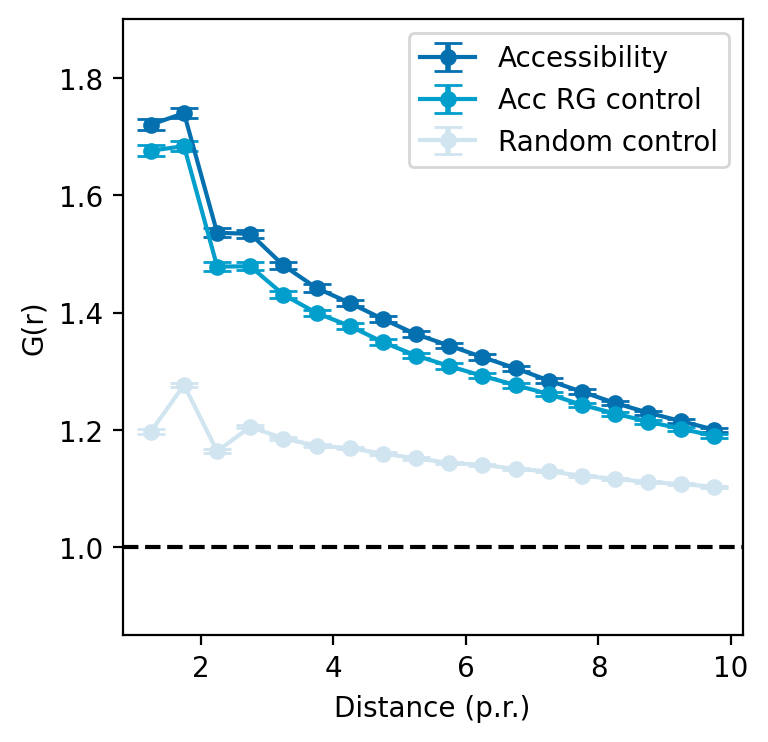

In [18]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
r = np.arange(0.25, 10, 0.5)
start_i = 2

plt.errorbar(r[start_i:],means_atac[start_i:],yerr=stderr_atac[start_i:],label='Accessibility',fmt='-o',ecolor='#0570b0',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#0570b0')
plt.errorbar(r[start_i:],means_atac_sample[start_i:],yerr=stderr_atac_sample[start_i:],label='Acc RG control',fmt='-o',ecolor='#029ecc',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#029ecc')
plt.errorbar(r[start_i:],means_atac_random[start_i:],yerr=stderr_atac_random[start_i:],label='Random control',fmt='-o',ecolor='#d1e5f0',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#d1e5f0')
#plt.errorbar(r[start_i:],means_ct_random[start_i:],yerr=stderr_ct_random[start_i:],label='H3K27me3',fmt='-o',ecolor='#93623f',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#93623f')
#plt.errorbar(r[start_i:],means_all[start_i:],yerr=stderr_all[start_i:],label='All',fmt='-o',ecolor='#bdbdbd',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#bdbdbd')

plt.axhline(y=1, color='black', linestyle='--')

plt.legend()
#plt.xlim(0.75, 8)
plt.ylim(0.85, 1.9)
plt.xlabel('Distance (p.r.)')
plt.ylabel('G(r)')
# save pdf
plt.savefig('figures/spatial_autocorr_atac_mesc_radial_pos_control.pdf', bbox_inches='tight')

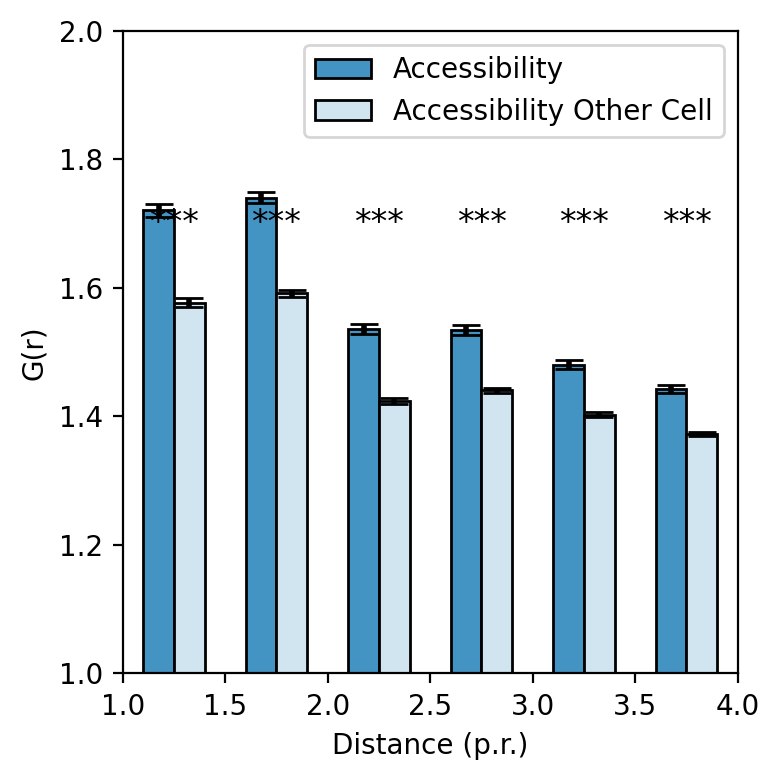

In [12]:
pdata=pd.DataFrame({"r":r,"means_atac":means_atac,"stderr_atac":stderr_atac,"means_atac_next":means_atac_next,"stderr_atac_next":stderr_atac_next,"means_allpoints":means_all,"stderr_allpoints":stderr_all})
p = [stats.mannwhitneyu(np.array(cor_atac)[:,i], np.array(cor_atac_next)[:,i])[1] for i in range(len(r))]

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))

bar_width = 0.15  # 设置条形图的宽度
index = r

plt.bar(index - bar_width / 2, pdata['means_atac'], bar_width, yerr=pdata['stderr_atac'], label='Accessibility', 
        color='#4393c3', edgecolor='black', capsize=5, error_kw={'elinewidth': 2, 'ecolor': 'black'})
plt.bar(index + bar_width / 2, pdata['means_atac_next'], bar_width, yerr=pdata['stderr_atac_next'], label='Accessibility Other Cell', 
        color='#d1e5f0', edgecolor='black', capsize=5, error_kw={'elinewidth': 2, 'ecolor': 'black'})

# 设置x轴的标签
plt.xlabel('Distance (p.r.)')
plt.ylabel('G(r)')
#plt.title('Spatial Autocorrelation')

for i in range(2,8):
    if p[i] < 0.001:
        plt.text(index[i], 1.7, '***', fontsize=12, ha='center', va='center', color='black')
    elif p[i] < 0.01:
        plt.text(index[i], 1.7, '**', fontsize=12, ha='center', va='center', color='black')
    elif p[i] < 0.05:
        plt.text(index[i], 1.7, '*', fontsize=12, ha='center', va='center', color='black')

plt.xlim(1, 4)
plt.ylim(1, 2)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/spatial_autocorr_atac_mesc_box.pdf', bbox_inches='tight')

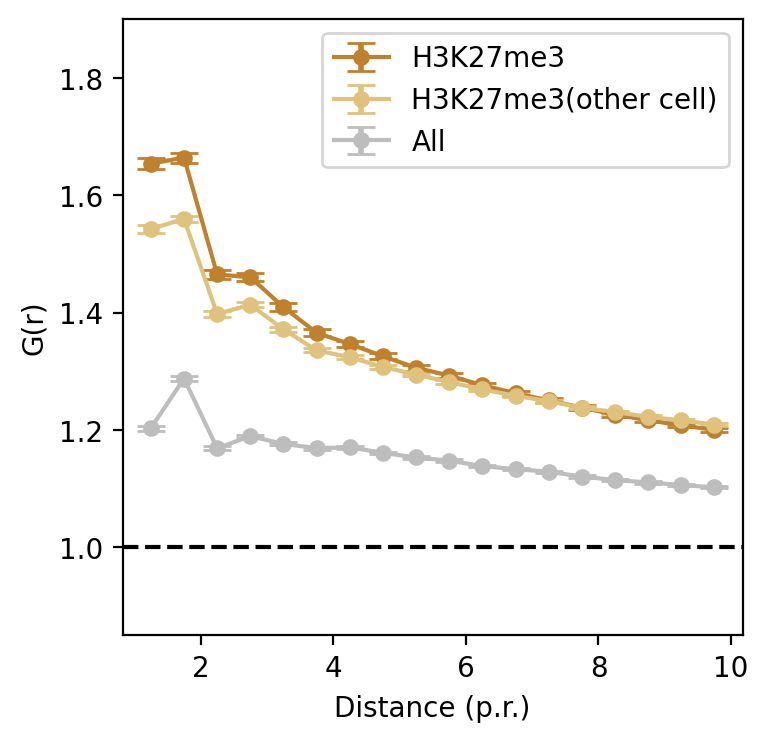

In [13]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
r = np.arange(0.25, 10, 0.5)
start_i = 2
plt.errorbar(r[start_i:],means_ct[start_i:],yerr=stderr_ct[start_i:],label='H3K27me3',fmt='-o',ecolor='#bf812d',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#bf812d')
plt.errorbar(r[start_i:],means_ct_next[start_i:],yerr=stderr_ct_next[start_i:],label='H3K27me3(other cell)',fmt='-o',ecolor='#dfc27d',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#dfc27d')
plt.errorbar(r[start_i:],means_all[start_i:],yerr=stderr_all[start_i:],label='All',fmt='-o',ecolor='#bdbdbd',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#bdbdbd')

plt.axhline(y=1, color='black', linestyle='--')

plt.legend()
#plt.xlim(0.75, 8)
plt.ylim(0.85, 1.9)
plt.xlabel('Distance (p.r.)')
plt.ylabel('G(r)')
# save pdf
plt.savefig('figures/spatial_autocorr_ct_mesc.pdf', bbox_inches='tight')

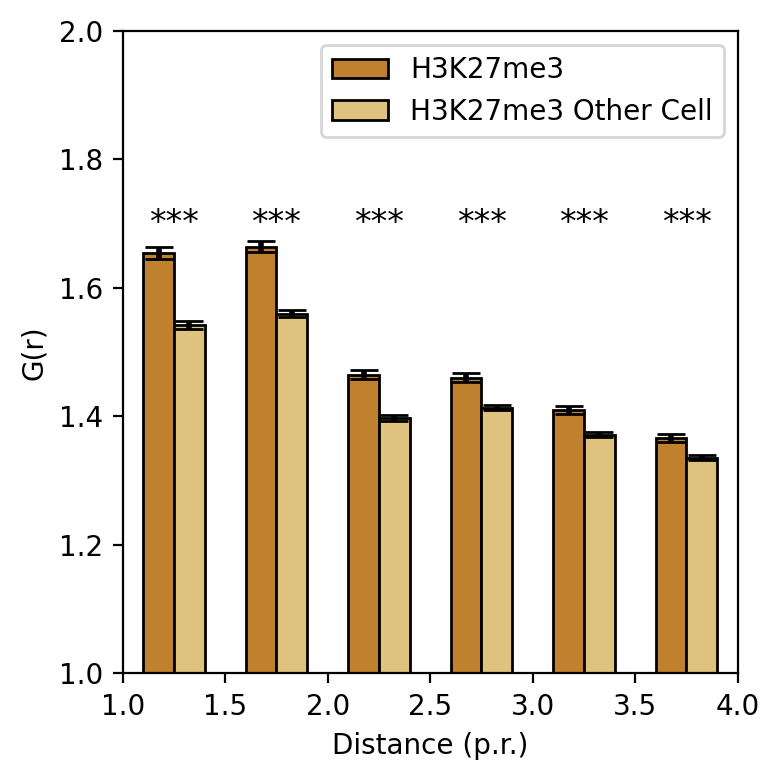

In [14]:
pdata = pd.DataFrame({"r":r,"means_ct":means_ct,"stderr_ct":stderr_ct,"means_ct_next":means_ct_next,"stderr_ct_next":stderr_ct_next,"means_allpoints":means_all,"stderr_allpoints":stderr_all})
p = [stats.mannwhitneyu(np.array(cor_ct)[:,i], np.array(cor_ct_next)[:,i])[1] for i in range(len(r))]

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))

bar_width = 0.15  # 设置条形图的宽度
index = r

plt.bar(index - bar_width / 2, pdata['means_ct'], bar_width, yerr=pdata['stderr_ct'], label='H3K27me3', 
        color='#bf812d', edgecolor='black', capsize=5, error_kw={'elinewidth': 2, 'ecolor': 'black'})
plt.bar(index + bar_width / 2, pdata['means_ct_next'], bar_width, yerr=pdata['stderr_ct_next'], label='H3K27me3 Other Cell', 
        color='#dfc27d', edgecolor='black', capsize=5, error_kw={'elinewidth': 2, 'ecolor': 'black'})

# 设置x轴的标签
plt.xlabel('Distance (p.r.)')
plt.ylabel('G(r)')
#plt.title('Spatial Autocorrelation')

for i in range(2,8):
    if p[i] < 0.001:
        plt.text(index[i], 1.7, '***', fontsize=12, ha='center', va='center', color='black')
    elif p[i] < 0.01:
        plt.text(index[i], 1.7, '**', fontsize=12, ha='center', va='center', color='black')
    elif p[i] < 0.05:
        plt.text(index[i], 1.7, '*', fontsize=12, ha='center', va='center', color='black')

plt.xlim(1, 4)
plt.ylim(1, 2)
plt.legend()
plt.tight_layout()

plt.savefig('figures/spatial_autocorr_ct_mesc_box.pdf', bbox_inches='tight')